# Blends guidlines

In [1]:
blend_example = {
    "name": "myRootBlend",
    "description": "an example of a Blend",
    "qmin": 1.0,
    "qmax": 1.0,
    "children": [
        {
            "name": "Solvent",
            "description": "Choose only one of the 3 following solvents",
            "qmin": 0.2,
            "qmax": 0.3,
            "cmax": 1,
            "children": [
                {
                    "name": "Solvent-1",
                    "description": "xxx"
                },
                {
                    "name": "Solvent-2",
                    "description": "yyy"
                },
                {
                    "name": "Solvent-3",
                    "description": "zzz"
                }
            ]
        },
        {
            "name": "Blend-A",
            "description": "Mix the following A components",
            "qmin": 0.4,
            "qmax": 0.7,
            "children": [
                {
                    "name": "Comp-A1",
                    "description": "xxx"
                },
                {
                    "name": "Comp-A2",
                    "description": "yyy"
                },
                {
                    "name": "Comp-A3",
                    "description": "zzz"
                }
            ]
        },
        {
            "name": "Component-B",
            "description": "zzz",
            "qmin": 0.1,
            "qmax": 0.3
        },
        {
            "name": "Component-C",
            "description": "zzz",
            "qmin": 0.0,
            "qmax": 0.2,
            "cmax": 1,
            "children": [
                {
                    "name": "Comp-C1",
                    "description": "xxx",
                    "children": [   
                        {
                            "name": "Comp-C1-1",
                            "description": "xxx"
                        },
                        {
                            "name": "Comp-C1-2",
                            "description": "yyy"
                        }
                    ]
                },
                {
                    "name": "Comp-C2",
                    "description": "yyy"
                },
            ]
        }        

    ]

}

In [2]:

class Component:
    """Core component, representing a fluid/material that can be added to a
    formulation in specified amounts.
    """

    def __init__(self, name, description=None, qmin=0, qmax=1):
        self.name = name
        self.description = description
        self.qmin = qmin
        self.qmax = qmax

class Blend:
    """Collection of Component or (sub-)Formulations.
    Note that we limited the recursivity of the operators not to make too complex Formulations:
    a Formulation can have as children Components, or another Formulation, but this child Formulation
    can only have Components as children (i.e., another Formulation).
    """

    def __init__(self, name, children, description=None, qmin=0.0, qmax=1.0, cmax=None):
        self.name = name
        self.description = description
        self.children = children
        self.qmin = qmin
        self.qmax = qmax
        self.cmax = len(self.children) if cmax is None else cmax


def dict_to_blend(children_dict):
    if 'children' in children_dict:
        children = []
        for child_dict in children_dict['children']:
            child = dict_to_blend(child_dict)
            children.append(child)
        
        children_dict_copy = children_dict.copy()
        children_dict_copy.pop('children')
        blend = Blend(**children_dict_copy, children=children)
        
        return blend

    else:
        component = Component(**children_dict)
        
        return component
    
blend = dict_to_blend(blend_example)

In [3]:
def blend_to_dict(blend):
    if isinstance(blend, Blend):
        children = []
        for child in blend.children:
            child_dict = blend_to_dict(child)
            children.append(child_dict)
        
        blend_dict = blend.__dict__.copy()
        blend_dict['children'] = children
        
        return blend_dict
    else:
        return blend.__dict__
    
out_dict = blend_to_dict(blend)
out_dict

{'name': 'myRootBlend',
 'description': 'an example of a Blend',
 'children': [{'name': 'Solvent',
   'description': 'Choose only one of the 3 following solvents',
   'children': [{'name': 'Solvent-1',
     'description': 'xxx',
     'qmin': 0,
     'qmax': 1},
    {'name': 'Solvent-2', 'description': 'yyy', 'qmin': 0, 'qmax': 1},
    {'name': 'Solvent-3', 'description': 'zzz', 'qmin': 0, 'qmax': 1}],
   'qmin': 0.2,
   'qmax': 0.3,
   'cmax': 1},
  {'name': 'Blend-A',
   'description': 'Mix the following A components',
   'children': [{'name': 'Comp-A1',
     'description': 'xxx',
     'qmin': 0,
     'qmax': 1},
    {'name': 'Comp-A2', 'description': 'yyy', 'qmin': 0, 'qmax': 1},
    {'name': 'Comp-A3', 'description': 'zzz', 'qmin': 0, 'qmax': 1}],
   'qmin': 0.4,
   'qmax': 0.7,
   'cmax': 3},
  {'name': 'Component-B', 'description': 'zzz', 'qmin': 0.1, 'qmax': 0.3},
  {'name': 'Component-C',
   'description': 'zzz',
   'children': [{'name': 'Comp-C1',
     'description': 'xxx',
   

In [4]:
def get_base_components(blend):
    if isinstance(blend, Blend):
        components = []
        for child in blend.children:
            components += get_base_components(child)
        
        return components
    else:
        return [blend]
    
base_components = get_base_components(blend)
base_components_names = [component.name for component in base_components]
base_components_names

['Solvent-1',
 'Solvent-2',
 'Solvent-3',
 'Comp-A1',
 'Comp-A2',
 'Comp-A3',
 'Component-B',
 'Comp-C1-1',
 'Comp-C1-2',
 'Comp-C2']

In [74]:
import numpy as np
import pandas as pd

def generate_children_quantities(blend, qparent=None, quants=None, qmethod="absolute"):
    """Made to be called recursively, generates the quantities of the children of a Blend.
    
    
    """
    # Validate the input
    if quants is None: # Root blend
        quants = {}
    if qparent is None: # Root blend
        qparent = np.random.uniform(blend.qmin, blend.qmax)
    assert qmethod in ["absolute", "relative"], "qmethod must be either 'absolute' or 'relative'"

    # Populate the quantities of the first offspring
    children_names = [child.name for child in blend.children]
    children_chosen = np.random.permutation(children_names)[:blend.cmax]
    qleft = 1.0 if qmethod == "relative" else qparent
    nchild = len(children_chosen)
    for ichild, child_name in enumerate(children_chosen):
        child = [child for child in blend.children if child.name == child_name][0]
        #print(child.name)
        if qleft < child.qmin:
            return None # there is no quantity left for the constraint
        if ichild==(nchild-1): # last child
            if qleft > child.qmax: # there is too much quantity left for the constraint
                return None
            quants[child_name] = qleft # assign the remaining quantity to the last child
        else:
            qchild = np.random.uniform(child.qmin, min(qleft, child.qmax)) 
            quants[child_name] = qchild
            qleft -= qchild

    if qmethod == "relative":
        for child_name in children_chosen:
            quants[child_name] *= qparent


    # Now that the quantities for the first offspring have been generated
    # we can reiterate recursively for the children that are themselves blends
    for child_name in children_chosen:
        child = [child for child in blend.children if child.name == child_name][0]
        #print(child.name)
        if isinstance(child, Blend):
            child_quants = generate_children_quantities(child, qparent=quants[child_name], qmethod=qmethod)
            if child_quants is None:
                return None
            quants.update(child_quants)
            del quants[child_name]

    return quants

for qmethod in ["absolute", "relative"]: 
    ntrials = 1000     
    trials = []
    for i in range(ntrials):
        trials.append(generate_children_quantities(blend, qmethod=qmethod))

    trials = [trial for trial in trials if trial is not None]

    df = pd.DataFrame(trials, columns=base_components_names).fillna(0)
    df["Qtot"] = df.sum(axis=1)

    print(f"Method: {qmethod}, {len(trials)}/{ntrials} successful trials") 
    display(df.head())

Method: absolute, 595/1000 successful trials


,Solvent-1,Solvent-2,Solvent-3,Comp-A1,Comp-A2,Comp-A3,Component-B,Comp-C1-1,Comp-C1-2,Comp-C2,Qtot
0,0.000000,0.0,0.201171,0.586417,0.003024,0.019817,0.187057,0.001776,0.000738,0.000000,1.0
1,0.233108,0.0,0.000000,0.103329,0.087886,0.233759,0.247635,0.000000,0.000000,0.094284,1.0
2,0.000000,0.0,0.254491,0.051282,0.146735,0.323629,0.165748,0.000022,0.058092,0.000000,1.0
3,0.206665,0.0,0.000000,0.438492,0.090741,0.111687,0.146285,0.000000,0.000000,0.006129,1.0
4,0.000000,0.0,0.279348,0.059650,0.314481,0.100437,0.173235,0.000000,0.000000,0.072849,1.0


Method: relative, 549/1000 successful trials


,Solvent-1,Solvent-2,Solvent-3,Comp-A1,Comp-A2,Comp-A3,Component-B,Comp-C1-1,Comp-C1-2,Comp-C2,Qtot
0,0.000000,0.0,0.271722,0.028478,0.099489,0.316924,0.276116,0.00667,0.000602,0.000000,1.0
1,0.215250,0.0,0.000000,0.124468,0.013086,0.364122,0.282685,0.00000,0.000000,0.000388,1.0
2,0.261764,0.0,0.000000,0.341802,0.051128,0.060663,0.277510,0.00000,0.000000,0.007134,1.0
3,0.000000,0.0,0.206157,0.170264,0.152613,0.201331,0.189651,0.00000,0.000000,0.079984,1.0
4,0.000000,0.0,0.213522,0.056729,0.183054,0.177924,0.299959,0.00000,0.000000,0.068811,1.0


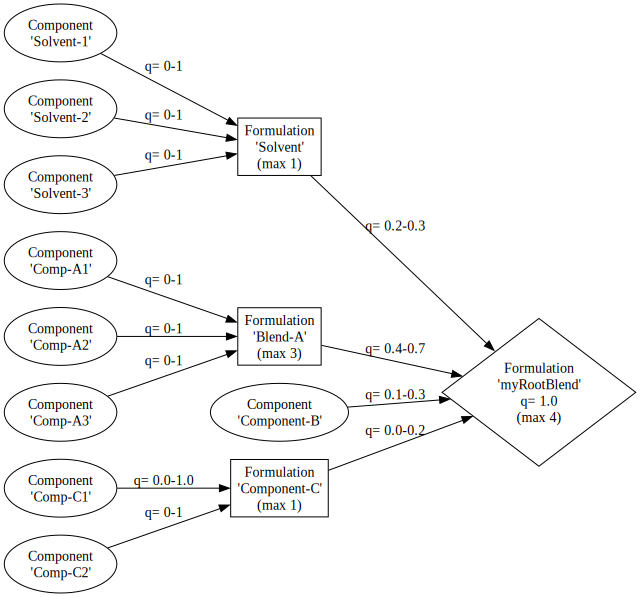

In [80]:
from graphviz import Digraph

def get_graph(
    frm,  #: Formulation
) -> Digraph:
    """Return a graphical representation of the input Formulation."""

    g = Digraph("Formulation")
    g.graph_attr["rankdir"] = "LR"
    if frm.qmin == frm.qmax:
        frm_q = f"q= {frm.qmin}"
    else:
        frm_q = f"q= {frm.qmin}-{frm.qmax}"
    frm_label = f"Formulation\n'{frm.name}'\n{frm_q}\n(max {frm.cmax})"
    g.node(frm_label, shape="diamond")
    for child in frm.children: # TODO: this comes from FormulX... needs to make it recursive!
        if isinstance(child, Component):
            g.node(f"Component\n'{child.name}'", shape="oval")
            g.edge(
                tail_name=f"Component\n'{child.name}'",
                head_name=frm_label,
                label=f"q= {child.qmin}-{child.qmax}",
            )
        else:  # child.fx_type=="formulation"
            g.node(f"Formulation\n'{child.name}'\n(max {child.cmax})", shape="box")
            g.edge(
                tail_name=f"Formulation\n'{child.name}'\n(max {child.cmax})",
                head_name=frm_label,
                label=f"q= {child.qmin}-{child.qmax}",
            )
            for child2 in child.children:
                g.node(f"Component\n'{child2.name}'", shape="oval")
                g.edge(
                    tail_name=f"Component\n'{child2.name}'",
                    head_name=f"Formulation\n'{child.name}'\n(max {child.cmax})",
                    label=f"q= {child2.qmin}-{child2.qmax}",
                )

    return g

g = get_graph(blend)
display(g)